# Computer Vision - Assignment 1
### Harshavardhan P
### 2021111003

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pprint as pp

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Q1: Own Calibration

### 1. Chess Board Corners

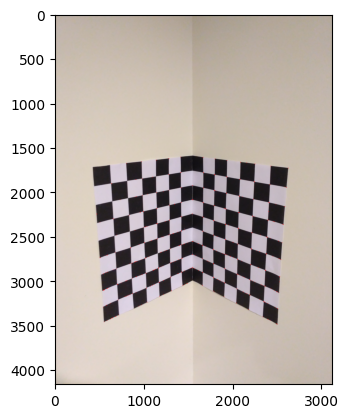

In [2]:
# Load the image
image = cv2.imread('calib-object.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find corners using Harris corner detection
corners = cv2.cornerHarris(gray, 2, 3, 0.04)

# Filter out points with high corner responses
threshold = 0.1 * corners.max()
corner_coords = np.argwhere(corners > threshold)

harr_image = image.copy()

# Plot the corners on the image
for corner in corner_coords:
    cv2.circle(harr_image, tuple(corner[::-1]), 3, (0, 0, 255), -1)

# Display the image with corners
plt.imshow(cv2.cvtColor(harr_image, cv2.COLOR_BGR2RGB))
plt.show()


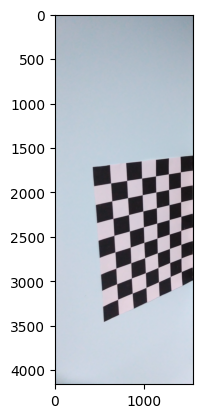

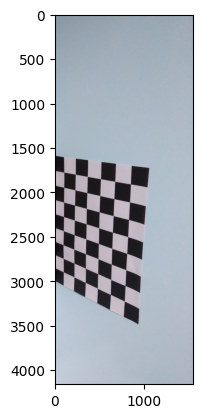

In [3]:
# split the image to 2 halves
left = image[:, :image.shape[1]//2]
right = image[:, image.shape[1]//2:]

plt.imshow(left)
plt.show()
plt.imshow(right)
plt.show()

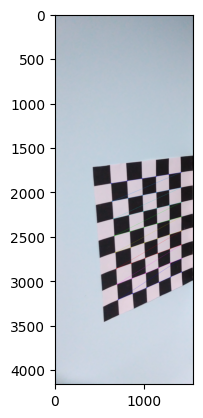

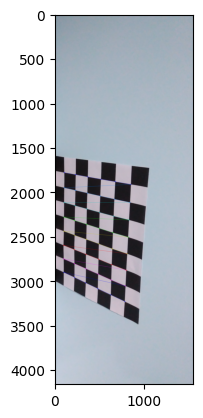

In [4]:
# applying chess board detection to the left and right images
gray_left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

chessboard_size = (6, 8)

ret, corners_left = cv2.findChessboardCorners(gray_left, chessboard_size, None)
ret, corners_right = cv2.findChessboardCorners(gray_right, chessboard_size, None)

if ret:
    corners_left = cv2.cornerSubPix(gray_left, corners_left, (11, 11), (-1, -1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
    corners_right = cv2.cornerSubPix(gray_right, corners_right, (11, 11), (-1, -1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

    cv2.drawChessboardCorners(left, chessboard_size, corners_left, ret)
    cv2.drawChessboardCorners(right, chessboard_size, corners_right, ret)

    plt.imshow(left)
    plt.show()
    plt.imshow(right)
    plt.show()
else:
    print("Chessboard corners not found.")

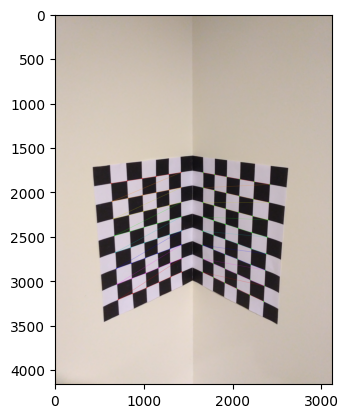

In [5]:
# Join the left and right halves back together
full_image = np.hstack((left, right))

# Add the offset to the x-coordinates of the corners in the right half
offset = left.shape[1]

# Draw corners on the full image
cv2.drawChessboardCorners(full_image, chessboard_size, corners_left, ret)
for corner in corners_right:
    corner[0][0] += offset  # Adding offset to x-coordinate
    # Convert corner coordinates to integers
    corner_int = tuple(map(int, corner[0]))
    cv2.circle(full_image, corner_int, 5, (0, 255, 0), -1)  # Draw green circles for corners in the right half

# Plot the full image with corners
plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
plt.show()

### 2. Camera Calibration

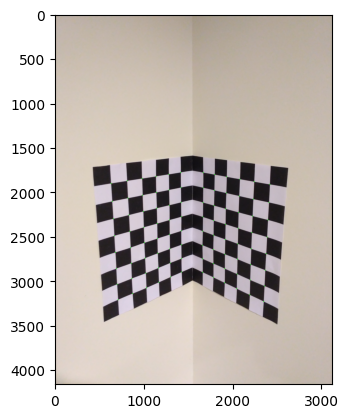

In [6]:
# convert all points to integers
corners_left = corners_left.squeeze().astype(int)
corners_right = corners_right.squeeze().astype(int)

# combine the corners
corners = np.vstack((corners_left, corners_right))

image = cv2.imread('calib-object.jpg')
full_image = image.copy()

# plot these points on the full image
for corner in corners:
    cv2.circle(full_image, tuple(corner), 5, (0, 255, 0), -1)

plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
print(corners)

[[ 629 1904]
 [ 809 1875]
 [ 977 1849]
 [1133 1825]
 [1277 1802]
 [1411 1780]
 [ 643 2105]
 [ 819 2069]
 [ 983 2036]
 [1136 2006]
 [1280 1977]
 [1413 1950]
 [ 655 2302]
 [ 830 2259]
 [ 990 2219]
 [1142 2183]
 [1284 2149]
 [1415 2116]
 [ 666 2493]
 [ 840 2444]
 [ 997 2397]
 [1146 2355]
 [1285 2315]
 [1417 2279]
 [ 678 2679]
 [ 848 2625]
 [1002 2571]
 [1149 2523]
 [1287 2479]
 [1416 2438]
 [ 688 2861]
 [ 856 2801]
 [1011 2744]
 [1153 2689]
 [1289 2640]
 [1417 2594]
 [ 697 3038]
 [ 862 2972]
 [1019 2913]
 [1160 2854]
 [1292 2799]
 [1419 2748]
 [ 707 3212]
 [ 871 3142]
 [1026 3078]
 [1166 3015]
 [1297 2955]
 [1421 2900]
 [1663 1782]
 [1792 1805]
 [1927 1830]
 [2075 1857]
 [2235 1885]
 [2411 1915]
 [1663 1953]
 [1788 1981]
 [1922 2012]
 [2067 2046]
 [2225 2081]
 [2401 2117]
 [1661 2119]
 [1784 2153]
 [1916 2190]
 [2060 2230]
 [2217 2271]
 [2390 2315]
 [1660 2281]
 [1781 2321]
 [1913 2363]
 [2055 2408]
 [2209 2457]
 [2380 2507]
 [1658 2441]
 [1779 2486]
 [1910 2533]
 [2051 2584]
 [2202 2639]

In [8]:
# considering center top junction point as the world origin
world_origin = [1544, 1593]

coords = corners.copy()

A = [
    # (1788 1981)
    [4, -4, 0, 1, 0, 0, 0, 0, -(1788 * 4), -(1788 * -4), -(1788 * 0), -(1788)],
    [0, 0, 0, 0, 4, -4, 0, 1, -(1981 * 4), -(1981 * -4), -(1981 * 0), -(1981)],
    # (2225 2081)
    [10, -4, 0, 1, 0, 0, 0, 0, -(2225 * 10), -(2225 * -4), -(2225 * 0), -(2225)],
    [0, 0, 0, 0, 10, -4, 0, 1, -(2081 * 10), -(2081 * -4), -(2081 * 0), -(2081)],
    # (1777 2806)
    [4, -14, 0, 1, 0, 0, 0, 0, -(1777 * 4), -(1777 * -14), -(1777 * 0), -(1777)],
    [0, 0, 0, 0, 4, -14, 0, 1, -(2806 * 4), -(2806 * -14), -(2806 * 0), -(2806)],
    # (2190 2989)
    [10, -14, 0, 1, 0, 0, 0, 0, -(2190 * 10), -(2190 * -14), -(2190 * 0), -(2190)],
    [0, 0, 0, 0, 10, -14, 0, 1, -(2989 * 10), -(2989 * -14), -(2989 * 0), -(2989)],
    # (1280 1977)
    [0, -4, 4, 1, 0, 0, 0, 0, -(1280 * 0), -(1280 * -4), -(1280 * 4), -(1280)],
    [0, 0, 0, 0, 0, -4, 4, 1, -(1977 * 0), -(1977 * -4), -(1977 * 4), -(1977)],
    # (819 2069)
    [0, -4, 10, 1, 0, 0, 0, 0, -(819 * 0), -(819 * -4), -(819 * 10), -(819)],
    [0, 0, 0, 0, 0, -4, 10, 1, -(2069 * 0), -(2069 * -4), -(2069 * 10), -(2069)],
    # (1292 2799)
    [0, -14, 4, 1, 0, 0, 0, 0, -(1292 * 0), -(1292 * -14), -(1292 * 4), -(1292)],
    [0, 0, 0, 0, 0, -14, 4, 1, -(2799 * 0), -(2799 * -14), -(2799 * 4), -(2799)],
    # (862 2972)
    [0, -14, 10, 1, 0, 0, 0, 0, -(862 * 0), -(862 * -14), -(862 * 10), -(862)],
    [0, 0, 0, 0, 0, -14, 10, 1, -(2972 * 0), -(2972 * -14), -(2972 * 10), -(2972)]
]

_, _, P = np.linalg.svd(A, full_matrices=True)

P = P[-1, :]

P = P.reshape(3, 4)

In [9]:
print(P)

[[-1.54951667e-02  3.52779334e-03  3.88225037e-02 -6.94255335e-01]
 [ 7.73548731e-03  4.18874406e-02  7.64507029e-03 -7.17200635e-01]
 [ 7.20771481e-06  2.24557436e-06  6.93748747e-06 -4.50955554e-04]]


In [10]:
M = P[:, :3].astype(np.float32)

MM = M @ M.T

# make both the variables float32 of numpy
u0 = MM[0, 2]
v0 = MM[1, 2]

b = np.sqrt(MM[1, 1] - v0**2)
g = (MM[1, 0] - u0 * v0) / b
a = np.sqrt(MM[0, 0] - u0**2 - g**2)

K = np.array([
    [a, g, u0],
    [0, b, v0],
    [0, 0, 1]
])

print(K)

[[4.12726921e-02 7.50313477e-03 1.65567798e-07]
 [0.00000000e+00 4.32763509e-02 2.02854125e-07]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



In [11]:
R = np.linalg.inv(K) @ M
print(R)

[[-4.07928920e-01 -9.04844257e-02  9.08518897e-01]
 [ 1.78746298e-01  9.67906002e-01  1.76656994e-01]
 [ 7.20771459e-06  2.24557425e-06  6.93748734e-06]]


In [12]:
t = np.linalg.inv(K) @ P[:, 3]
print(t)

[-1.38083811e+01 -1.65725765e+01 -4.50955554e-04]


### 3. Wireframing

In [13]:
wf_world_coords = []
for i in range(8):
    for j in range(10):
        wf_world_coords.append([2*i, -2*j, 0, 1])
        wf_world_coords.append([0, -2*j, 2*i, 1])

wf_world_coords = np.array(wf_world_coords)
print(len(wf_world_coords))
print(wf_world_coords)

160
[[  0   0   0   1]
 [  0   0   0   1]
 [  0  -2   0   1]
 [  0  -2   0   1]
 [  0  -4   0   1]
 [  0  -4   0   1]
 [  0  -6   0   1]
 [  0  -6   0   1]
 [  0  -8   0   1]
 [  0  -8   0   1]
 [  0 -10   0   1]
 [  0 -10   0   1]
 [  0 -12   0   1]
 [  0 -12   0   1]
 [  0 -14   0   1]
 [  0 -14   0   1]
 [  0 -16   0   1]
 [  0 -16   0   1]
 [  0 -18   0   1]
 [  0 -18   0   1]
 [  2   0   0   1]
 [  0   0   2   1]
 [  2  -2   0   1]
 [  0  -2   2   1]
 [  2  -4   0   1]
 [  0  -4   2   1]
 [  2  -6   0   1]
 [  0  -6   2   1]
 [  2  -8   0   1]
 [  0  -8   2   1]
 [  2 -10   0   1]
 [  0 -10   2   1]
 [  2 -12   0   1]
 [  0 -12   2   1]
 [  2 -14   0   1]
 [  0 -14   2   1]
 [  2 -16   0   1]
 [  0 -16   2   1]
 [  2 -18   0   1]
 [  0 -18   2   1]
 [  4   0   0   1]
 [  0   0   4   1]
 [  4  -2   0   1]
 [  0  -2   4   1]
 [  4  -4   0   1]
 [  0  -4   4   1]
 [  4  -6   0   1]
 [  0  -6   4   1]
 [  4  -8   0   1]
 [  0  -8   4   1]
 [  4 -10   0   1]
 [  0 -10   4   1]
 [  4 -1

In [14]:
wf_image_coords = []
for point in wf_world_coords:
    wf_image_coords.append(np.dot(P, point))

wf_image_coords = np.array(wf_image_coords)
print(len(wf_image_coords))

160


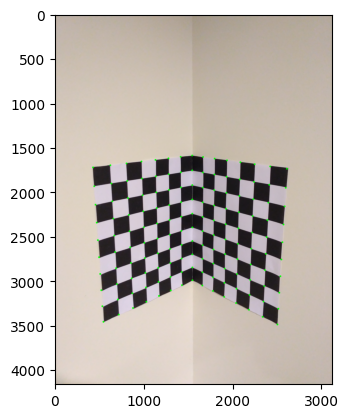

In [15]:
# plot all the wf_image_coords on the image
image = cv2.imread('calib-object.jpg')
full_image = image.copy()

for point in wf_image_coords:
    point = point / point[-1]
    cv2.circle(full_image, tuple(point[:-1].astype(int)), 10, (0, 255, 0), -1)

plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
plt.show()

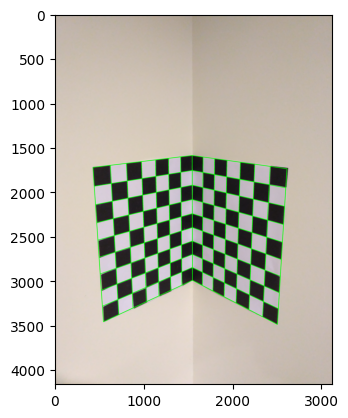

In [16]:
# lines between every pair of adjacent points in the world frame, in the image coords
lines = []

for i in range(len(wf_world_coords)):
    for j in range(len(wf_world_coords)):
        if i != j:
            if wf_world_coords[i][2] == 0 and wf_world_coords[j][2] == 0 and (wf_world_coords[i][0] == wf_world_coords[j][0] or wf_world_coords[i][1] == wf_world_coords[j][1]):
                lines.append([wf_image_coords[i], wf_image_coords[j]])
            elif wf_world_coords[i][0] == 0 and wf_world_coords[j][0] == 0 and (wf_world_coords[i][1] == wf_world_coords[j][1] or wf_world_coords[i][2] == wf_world_coords[j][2]):
                lines.append([wf_image_coords[i], wf_image_coords[j]])
            else:
                continue

lines = np.array(lines)

# plot all the lines
image = cv2.imread('calib-object.jpg')
full_image = image.copy()

for line in lines:
    # cv2.line(full_image, tuple(line[0].astype(int)), tuple(line[1].astype(int)), (0, 255, 0), 1)
    point1 = line[0] / line[0][-1]
    point2 = line[1] / line[1][-1]
    cv2.line(full_image, tuple(point1[:-1].astype(int)), tuple(point2[:-1].astype(int)), (0, 255, 0), 5)

plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
plt.show()

### 4. Rotation angles

In [17]:
# pan (rotation about the z-axis), tilt (rotation about the x-axis), and roll (rotation about the y-axis)
pan = np.arctan2(R[1, 0], R[0, 0])
tilt = np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2))
roll = np.arctan2(R[2, 1], R[2, 2])

print("Pan: ", np.degrees(pan))
print("Tilt: ", np.degrees(tilt))
print("Roll: ", np.degrees(roll))

Pan:  156.33792810590873
Tilt:  -44.667468826081134
Roll:  17.93609138268306


## Q2: OpenCV Calibration

### 1. Calibration using OpenCV

In [20]:
initial_intrinsic_matrix = np.array(K, dtype=np.float32)
initial_intrinsic_matrix = np.array([
    [initial_intrinsic_matrix[0, 0], 0, initial_intrinsic_matrix[0, 2]],
    [0, initial_intrinsic_matrix[1, 1], initial_intrinsic_matrix[1, 2]],
    [0, 0, 1]
], dtype=np.float32)
initial_distortion_coefficients = np.array([0, 0, 0, 0, 0], dtype=np.float32)

A = [
    # (1788 1981)
    [4, -4, 0, 1, 0, 0, 0, 0, -(1788 * 4), -(1788 * -4), -(1788 * 0), -(1788)],
    [0, 0, 0, 0, 4, -4, 0, 1, -(1981 * 4), -(1981 * -4), -(1981 * 0), -(1981)],
    # (2225 2081)
    [10, -4, 0, 1, 0, 0, 0, 0, -(2225 * 10), -(2225 * -4), -(2225 * 0), -(2225)],
    [0, 0, 0, 0, 10, -4, 0, 1, -(2081 * 10), -(2081 * -4), -(2081 * 0), -(2081)],
    # (1777 2806)
    [4, -14, 0, 1, 0, 0, 0, 0, -(1777 * 4), -(1777 * -14), -(1777 * 0), -(1777)],
    [0, 0, 0, 0, 4, -14, 0, 1, -(2806 * 4), -(2806 * -14), -(2806 * 0), -(2806)],
    # (2190 2989)
    [10, -14, 0, 1, 0, 0, 0, 0, -(2190 * 10), -(2190 * -14), -(2190 * 0), -(2190)],
    [0, 0, 0, 0, 10, -14, 0, 1, -(2989 * 10), -(2989 * -14), -(2989 * 0), -(2989)],
    # (1280 1977)
    [0, -4, 4, 1, 0, 0, 0, 0, -(1280 * 0), -(1280 * -4), -(1280 * 4), -(1280)],
    [0, 0, 0, 0, 0, -4, 4, 1, -(1977 * 0), -(1977 * -4), -(1977 * 4), -(1977)],
    # (819 2069)
    [0, -4, 10, 1, 0, 0, 0, 0, -(819 * 0), -(819 * -4), -(819 * 10), -(819)],
    [0, 0, 0, 0, 0, -4, 10, 1, -(2069 * 0), -(2069 * -4), -(2069 * 10), -(2069)],
    # (1292 2799)
    [0, -14, 4, 1, 0, 0, 0, 0, -(1292 * 0), -(1292 * -14), -(1292 * 4), -(1292)],
    [0, 0, 0, 0, 0, -14, 4, 1, -(2799 * 0), -(2799 * -14), -(2799 * 4), -(2799)],
    # (862 2972)
    [0, -14, 10, 1, 0, 0, 0, 0, -(862 * 0), -(862 * -14), -(862 * 10), -(862)],
    [0, 0, 0, 0, 0, -14, 10, 1, -(2972 * 0), -(2972 * -14), -(2972 * 10), -(2972)]
]

world_points = [
    [4, -4, 0],
    [10, -4, 0],
    [4, -14, 0],
    [10, -14, 0],
    [0, -4, 4],
    [0, -4, 10],
    [0, -14, 4],
    [0, -14, 10]
]

image_points = [
    [1788, 1981],
    [2225, 2081],
    [1777, 2806],
    [2190, 2989],
    [1280, 1977],
    [819, 2069],
    [1292, 2799],
    [862, 2972]
]

world_points = np.array(world_points, dtype=np.float32)
image_points = np.array(image_points, dtype=np.float32)

_, K_, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(
    [world_points], [image_points], (image.shape[0], image.shape[1]), initial_intrinsic_matrix, initial_distortion_coefficients, flags=cv2.CALIB_USE_INTRINSIC_GUESS
)

print(K_)
print(dist_coeff)
print(rvecs)
print(tvecs)

[[4.12726924e-02 0.00000000e+00 1.65567798e-07]
 [0.00000000e+00 4.32763509e-02 2.02854125e-07]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[9.14346538e-53]
 [5.83632528e-43]
 [2.93979219e-57]
 [1.85010788e-57]
 [3.81854202e-33]]
(array([[-2239.51596573],
       [-2433.97907983],
       [ 1312.16665664]]),)
(array([[-1.21331059e+06],
       [-1.86875231e+06],
       [-4.21736847e+01]]),)


In [36]:
# getting P_ from the camera calibration
R_ = cv2.Rodrigues(rvecs[0])[0]
RT_ = np.hstack((R, tvecs[0]))
P_ = K_ @ RT_

print(R_)
print(tvecs[0])
print(RT_)
print(P_)

[[ 0.13787659  0.28127278 -0.94967135]
 [ 0.94795999  0.24035022  0.20881483]
 [ 0.28698765 -0.92904111 -0.23349668]]
[[-1.21331059e+06]
 [-1.86875231e+06]
 [-4.21736847e+01]]
[[ 1.37876586e-01  2.81272785e-01 -9.49671347e-01 -1.21331059e+06]
 [ 9.47959986e-01  2.40350224e-01  2.08814833e-01 -1.86875231e+06]
 [ 2.86987650e-01 -9.29041114e-01 -2.33496677e-01 -4.21736847e+01]]
[[ 5.69058544e-03  1.16087313e-02 -3.91955320e-02 -5.00765948e+04]
 [ 4.10243073e-02  1.04012922e-02  9.03669661e-03 -8.08727806e+04]
 [ 2.86987650e-01 -9.29041114e-01 -2.33496677e-01 -4.21736847e+01]]


In [34]:
wf_world_coords_ = wf_world_coords.copy()
wf_world_coords_ = np.array(wf_world_coords_, dtype=np.float32)

wf_image_coords_ = []

for point in wf_world_coords_:
    point = np.dot(P_, point)
    wf_image_coords_.append(point)

wf_image_coords_ = np.array(wf_image_coords_)
print(len(wf_image_coords_))

160


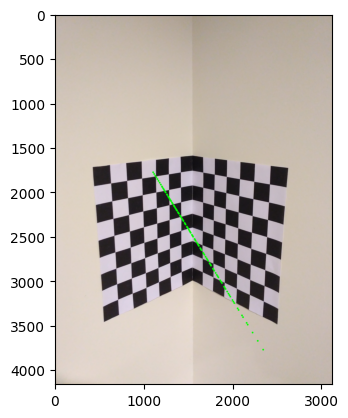

In [37]:
# plot all the wf_image_coords on the image
image = cv2.imread('calib-object.jpg')
full_image = image.copy()

for point in wf_image_coords_:
    point = point / point[-1]
    cv2.circle(full_image, tuple(point[:-1].astype(int)), 10, (0, 255, 0), -1)

plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
plt.show()